In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class DeepfakeDetectorCNN(nn.Module):
    def __init__(self):
        super(DeepfakeDetectorCNN, self).__init__()
        
        # Blocs de convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Utilisation de LeakyReLU pour éviter les "neurones morts"
        self.activation = nn.LeakyReLU(0.1)
        
        # Fully Connected layers
        self.fc1 = nn.Linear(512 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Passage dans les couches avec LeakyReLU
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.pool(self.activation(self.bn5(self.conv5(x))))
        
        x = x.view(x.size(0), -1) # Flatten dynamique
        
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        
        # IMPORTANT : On ne met PAS de Sigmoid ici si tu utilises BCEWithLogitsLoss
        # Si tu veux des probabilités (0 à 1) après, tu feras torch.sigmoid(output) 
        # uniquement lors de l'inférence (test).
        x = self.fc2(x)
        return x

🚀 Collecting model outputs...

--- 🔍 THRESHOLD DIAGNOSTIC ---
Threshold 0.30 -> Acc: 0.8984 | CM: [[6326, 672], [750, 6247]]
Threshold 0.50 -> Acc: 0.8802 | CM: [[6586, 412], [1264, 5733]]
Threshold 0.70 -> Acc: 0.8404 | CM: [[6756, 242], [1992, 5005]]
Threshold 0.80 -> Acc: 0.8078 | CM: [[6841, 157], [2533, 4464]]
Threshold 0.90 -> Acc: 0.7461 | CM: [[6927, 71], [3483, 3514]]
Threshold 0.95 -> Acc: 0.6835 | CM: [[6962, 36], [4394, 2603]]
Threshold 0.99 -> Acc: 0.5737 | CM: [[6990, 8], [5958, 1039]]

✅ Best Threshold found: 0.3 with Accuracy: 0.8984

--- FINAL CLASSIFICATION REPORT (Best Threshold) ---
              precision    recall  f1-score   support

        Fake       0.89      0.90      0.90      6998
        Real       0.90      0.89      0.90      6997

    accuracy                           0.90     13995
   macro avg       0.90      0.90      0.90     13995
weighted avg       0.90      0.90      0.90     13995



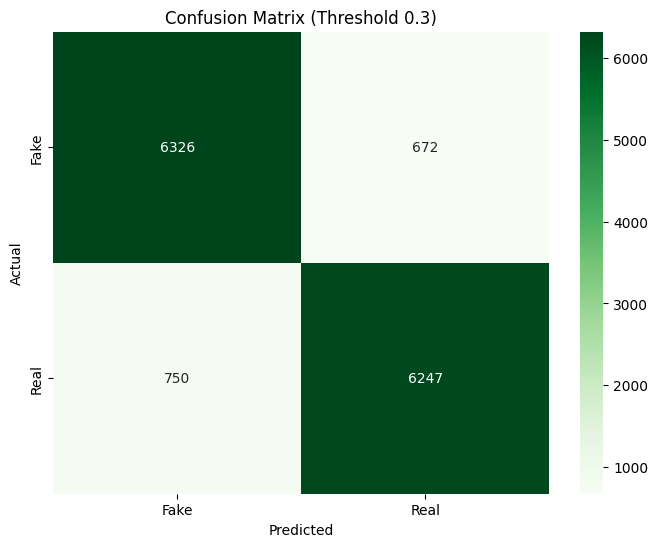

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


val_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Ajouté pour égaliser la taille des images (256x256)
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
])


test_dataset = datasets.ImageFolder("../images/test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




model = DeepfakeDetectorCNN().to(device)
checkpoint = torch.load("../models/ai_detector.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#evaluation loop to collect all outputs and labels

all_outputs = []
all_labels = []

print("🚀 Collecting model outputs...")
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # APPLIQUER LA SIGMOID ICI
        probs = torch.sigmoid(outputs) 
        all_outputs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_outputs = np.array(all_outputs).flatten()
all_labels = np.array(all_labels)


best_acc = 0
best_threshold = 0.5

#diverse thresholds to test
print("\n--- 🔍 THRESHOLD DIAGNOSTIC ---")
for t in [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99]:
    preds = (all_outputs > t).astype(float)
    cm = confusion_matrix(all_labels, preds)
    acc = (preds == all_labels).mean()
    print(f"Threshold {t:.2f} -> Acc: {acc:.4f} | CM: {cm.tolist()}")
    
    if acc > best_acc:
        best_acc = acc
        best_threshold = t


print(f"\n✅ Best Threshold found: {best_threshold} with Accuracy: {best_acc:.4f}")

final_preds = (all_outputs > best_threshold).astype(float)
print("\n--- FINAL CLASSIFICATION REPORT (Best Threshold) ---")
print(classification_report(all_labels, final_preds, target_names=['Fake', 'Real']))

#confusion matrix
cm = confusion_matrix(all_labels, final_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold {best_threshold})')
plt.show()

In [5]:
print(f"Lien Dossier <-> Label : {test_dataset.class_to_idx}")

Lien Dossier <-> Label : {'fake': 0, 'real': 1}


In [7]:
import torch
import os

checkpoint = torch.load("../models/ai_detector.pt", map_location='cpu')

print("--- 📦 Contenu du fichier ---")
for key in checkpoint.keys():
    print(f"Clé trouvée : {key}")

# Calculer le nombre de paramètres
if 'model_state_dict' in checkpoint:
    params = sum(p.numel() for p in checkpoint['model_state_dict'].values())
    size_mb = (params * 4) / (1024**2)  # 1 param float32 = 4 octets
    print(f"\n--- 📊 Statistiques ---")
    print(f"Nombre de paramètres : {params:,}")
    print(f"Poids théorique des poids seuls : {size_mb:.2f} MB")
    
file_size = os.path.getsize("../models/ai_detector.pt") / (1024**2)
print(f"Taille réelle sur le disque : {file_size:.2f} MB")

--- 📦 Contenu du fichier ---
Clé trouvée : epoch
Clé trouvée : model_state_dict
Clé trouvée : optimizer_state_dict
Clé trouvée : f1_score
Clé trouvée : val_loss

--- 📊 Statistiques ---
Nombre de paramètres : 18,350,790
Poids théorique des poids seuls : 70.00 MB
Taille réelle sur le disque : 210.03 MB


In [8]:
checkpoint = torch.load("../models/ai_detector.pt")
# On n'extrait QUE les poids
torch.save(checkpoint['model_state_dict'], "../models/ai_detector.pth")
print("✅ Fichier de .pth généré !")

✅ Fichier de .pth généré !
